# Text Classification with RNNs on AG_NEWS Dataset

## 👥 Team Members

- [Carlos Salguero](https://github.com/salgue441)
- [Diego Perdomo](https://github.com/DiegoPerdomoS)
- [Luis Arturo](https://github.com/00sen)
- [José Riosmena](https://github.com/Riosmena)
- [Dafne](https://github.com/Dafne224)

## 📋 Project Overview

This notebook implements a text classification system using Recurrent Neural Networks (RNNs) on the AG_NEWS dataset.

### Dataset Description

The AG_NEWS dataset consists of news articles collected from more than 2000 news sources. Each article is categorized into one of four classes:

1. World
2. Sports
3. Business
4. Science / Technology

### 🎯 Technical Objectives

- **Data Processing**: implement efficient text preprocessing and tokenization.
- **Model Architecture**: build a robust RNN-based classification model.
- **Training Pipeline**: develop an effective training loop with performance monitoring.
- **Evaluation**: Implement comprehensive model evaluation metrics.

## 📊 Evaluation Criteria

| Component            | Weight | Success Criteria                                                      |
| -------------------- | ------ | --------------------------------------------------------------------- |
| Setup & Organization | 10 %   | Proper library implementation and code structure                      |
| Code Quality         | 30 %   | Clear documentation, efficient implementation, proper use of markdown |
| Model Implementation | 20 %   | Correct RNN architecture and forward pass                             |
| Training Functions   | 10 %   | Effective training loop with proper optimization                      |
| Accuracy Metrics     | 10 %   | Comprehensive evaluation metrics                                      |
| Text Sampling        | 10 %   | Functional classification of new text                                 |
| Confusion Matrix     | 10 %   | Clear visualization and analysis                                      |


## 🛠️ Requied Libraries


In [77]:
from typing import List, Tuple, Dict
from collections import Counter
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [78]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1+cu124


In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

print(f"Using device: {device}")

Using device: cuda


## News Dataset for Text Classification


In [80]:
class NewsDataset(Dataset):
    """
    Custom dataset class for handling AG_NEWS data.

    This class manages text preprocessing, vocabulary building, and tokenization.

    Attributes:
        text (List[str]): List of input text documents.
        labels (List[int]): Corresponding classification labels.
        max_length (int): Maximum sequence length for padding / truncation.
        vocab (Dict[str, int]): Word-to-index mapping dictionary.
    """

    def __init__(self, texts: List[str], labels: List[int], vocab=None, max_length=100):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

        if vocab is None:
            self.vocab = self._build_vocab()

        else:
            self.vocab = vocab

    def _build_vocab(self, min_freq: int = 5):
        """
        Build a vocabulary dictionary with word frequencies.

        Args:
            min_freq (int): Minimum frequency threshold for including a word in the vocabulary.

        Returns:
            Dict[str, int]: Word-to-index mapping dictionary.
        """

        word_counts = Counter()
        for text in self.texts:
            words = self._tokenize(text)
            word_counts.update(words)

        vocab = {"<PAD>": 0, "<UNK>": 1}
        for word, count in word_counts.items():
            if count >= min_freq:
                vocab[word] = len(vocab)

        return vocab

    def _tokenize(self, text: str) -> List[str]:
        """
        Tokenize input text into words using a simple whitespace tokenizer.

        Args:
            text (str): Input text string.

        Returns:
            List[str]: List of words in the input text.
        """

        words = re.findall(r"\b\w+\b", text.lower())
        return words

    def _convert_to_ids(self, tokens: List[str]) -> List[int]:
        """
        Convert a list of tokens to a list of corresponding word indices.

        Args:
            tokens (List[str]): List of input words.

        Returns:
            List[int]: List of word indices.
        """

        tokens = tokens[: self.max_length]
        ids = [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]

        if len(ids) < self.max_length:
            ids += [self.vocab["<PAD>"]] * (self.max_length - len(ids))

        return ids

    def __len__(self):
        """
        Compute the total number of data points in the dataset.

        Returns:
            int: Number of data points in the dataset.
        """
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate a preprocessed data sample from the dataset at the given index.

        Args:
            idx (int): Index of the data sample.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple of input and target tensors.
        """

        text = self.texts[idx]
        label = self.labels[idx]

        tokens = self._tokenize(text)
        ids = self._convert_to_ids(tokens)

        return (
            torch.tensor(ids, dtype=torch.long),
            torch.tensor(label, dtype=torch.long),
        )

In [81]:
def load_ag_news(file_path: str) -> Tuple[List[str], List[int]]:
    """
    Loads and preprocesses AG_NEWS dataset from a CSV file.

    Args:
        file_path (str): Path to the CSV file containing news data.

    Returns:
        Tuple[List[str], List[int]]: Processed texts and their labels.

    Features:
        - Handles both header and header-less CSV files.
        - Combines title and description for full text representation.
        - Provides error handling and data loading diagnostics.
        - Reports label distribution statistics.
    """

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            first_line = f.readline().strip()
            has_header = first_line.startswith("Class Index") or first_line.startswith(
                "class"
            )

        df = pd.read_csv(
            file_path,
            header=0 if has_header else None,
            names=["label", "title", "description"],
            encoding="utf-8",
        )

        labels, texts = [], []
        for idx, row in df.iterrows():
            try:
                label = int(str(row["label"]).strip("\"' ")) - 1
                title = str(row["title"]).strip("\"' ")
                description = str(row["description"]).strip("\"' ")
                full_text = f"{title}. {description}"

                labels.append(label)
                texts.append(full_text)
            except Exception as e:
                print(f"Skipping row {idx} due to error: {str(e)}")
                continue

        print(f"Successfully loaded {len(texts)} samples from {file_path}")
        print(f"Label distribution: {Counter(labels)}")

        return texts, labels

    except Exception as e:
        print(f"Error loading file {file_path}: {str(e)}")
        print("\nFirst few lines of the file:")
        with open(file_path, "r", encoding="utf-8") as f:
            print(f.read(500))

        raise

## Text Classifier


In [82]:
class TextClassifier(nn.Module):
    """
    Rnn-based text classification model using bidirectional GRU.

    Architecture:
        1. Embedding layer: converts word indices to dense vectors.
        2. Bidirectional GRU: processes the input sequences in both directions.
        3. Fully connected layer: maps GRU output to class labels.

    Args:
        vocab_size (int): Size of the vocabulary (number of tokens).
        embed_size (int): Size of the word embeddings.
        hidden_size (int): Size of the hidden units in GRU.
        num_layers (int): Number of GRU layers.
        num_classes (int): Number of output classes.
        dropout (float): Dropout rate to apply between GRU layers.
    """

    def __init__(
        self,
        vocab_size: int,
        embed_size: int = 300,
        hidden_size: int = 256,
        num_layers: int = 2,
        num_classes: int = 4,
        dropout: float = 0.3,
    ):
        super(TextClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(
            embed_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
        )

        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the classifier.

        Args:
            x (torch.Tensor): Input tensor of token indices.

        Returns:
            torch.Tensor: Output tensor of class logits.
        """

        embedded = self.dropout(self.embedding(x))
        output, hidden = self.gru(embedded)

        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        hidden = self.dropout(hidden)

        return self.fc(hidden)

## Trainer


In [83]:
class Trainer:
    """
    Manages the training process for the text classification model.

    Features:
        - Implements training and evaluation loops.
        - Track metrics and learning progress.
        - Provides early stopping mechanisms.
        - Saves the best model state during training.
        - Generates confusion matrices for evaluation.

    Args:
        model (nn.Module): Text classification model to train.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        test_loader (DataLoader): Test data loader.
        criterion (nn.Module): Loss function for optimization.
        lr (float): Learning rate for the optimizer.
        device (torch.device): Device to run the training on.
    """

    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        test_loader: DataLoader,
        criterion: nn.Module = nn.CrossEntropyLoss(),
        lr: float = 0.001,
        device: torch.device = device,
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.device = device
        self.best_model_path = "best_model.pt"

    def calculate_metrics(self, loader: DataLoader) -> Dict[str, float]:
        """
        Calculates accuracy, F1-score (micro, macro, weighted) and per-class metrics.

        Args:
            loader (DataLoader): Data loader to evaluate the model on.

        Returns:
            Dict[str, float]: Dictionary of metric names and their values.
        """

        self.model.eval()

        all_preds, all_labels = [], []
        total_loss: float = 0.0

        with torch.no_grad():
            for batch in tqdm(loader, desc="Calculating metrics", leave=False):
                x, y = [t.to(self.device) for t in batch]
                output = self.model(x)
                loss = self.criterion(output, y)

                _, predicted = torch.max(output, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

                total_loss += loss.item()

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        f1_micro = f1_score(all_labels, all_preds, average="micro")
        f1_macro = f1_score(all_labels, all_preds, average="macro")
        f1_weighted = f1_score(all_labels, all_preds, average="weighted")
        f1_per_class = f1_score(all_labels, all_preds, average=None)

        accuracy = (all_preds == all_labels).mean()
        report = classification_report(all_labels, all_preds, output_dict=True)

        return {
            "loss": total_loss / len(loader),
            "accuracy": accuracy,
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "f1_per_class": f1_per_class,
            "classification_report": report,
        }

    def train_epoch(self) -> Tuple[float, float]:
        """
        Trains the model for one epoch of the data loader.

        Returns:
            Tuple[float, float]: Average loss and accuracy for the epoch.
        """

        self.model.train()
        total_loss: float = 0.0

        all_preds, all_labels = [], []
        for batch in tqdm(self.train_loader, desc="Training", leave=False):
            x, y = [t.to(self.device) for t in batch]
            self.optimizer.zero_grad()

            output = self.model(x)
            loss = self.criterion(output, y)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

        metrics = {
            "loss": total_loss / len(self.train_loader),
            "accuracy": (np.array(all_preds) == np.array(all_labels)).mean(),
            "f1_weighted": f1_score(all_labels, all_preds, average="weighted"),
        }

        return metrics

    def evaluate(self, loader: DataLoader) -> Tuple[float, float]:
        """
        Evaluates the model on the given data loader.

        Args:
            loader (DataLoader): Data loader to evaluate the model on.

        Returns:
            Tuple[float, float]: Average loss and accuracy on the data loader.
        """

        return self.calculate_metrics(loader)

    def save_model(self):
        """
        Saves the best model weights to a file.
        """

        torch.save(self.model.state_dict(), self.best_model_path)

    def load_model(self):
        """
        Loads the best model weights from a file.
        """

        self.model.load_state_dict(torch.load(self.best_model_path))

    def train(
        self, epochs: int, early_stopping_patience: int = 3
    ) -> List[Dict[str, float]]:
        """
        Trains the model for a fixed number of epochs.

        Args:
            epochs (int): Number of epochs to train the model.
            early_stopping_patience (int): Number of epochs to wait before early stopping.

        Returns:
            List[Dict[str, float]]: History of training and validation metrics.
        """

        best_val_f1, patience_counter = 0, 0
        history = []

        for epoch in range(epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.evaluate(self.val_loader)

            history.append(
                {
                    "epoch": epoch + 1,
                    **{f"train_{k}": v for k, v in train_metrics.items()},
                    **{
                        f"val_{k}": v
                        for k, v in val_metrics.items()
                        if k not in ["classification_report", "f1_per_class"]
                    },
                }
            )

            print(
                f"Epoch {epoch + 1}/{epochs}, Train (loss: {train_metrics['loss']:.4f}, accuracy: {train_metrics['accuracy']:.4f}), "
                f"Val (loss: {val_metrics['loss']:.4f}, accuracy: {val_metrics['accuracy']:.4f})"
            )

            if val_metrics["f1_weighted"] > best_val_f1:
                best_val_f1 = val_metrics["f1_weighted"]
                self.save_model()
                patience_counter = 0

            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print(
                    f"Stopping early at epoch {epoch + 1} with no improvement in validation loss."
                )

                break

        self.load_model()
        return history

    def create_confusion_matrix(self, loader: DataLoader = None):
        """
        Creates a confusion matrix for the model on the given data loader.

        Args:
            loader (DataLoader): Data loader to evaluate the model on.

        Returns:
            np.ndarray: Confusion matrix of model predictions.
        """

        if loader is None:
            loader = self.test_loader

        self.model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in loader:
                x, y = [t.to(self.device) for t in batch]
                output = self.model(x)
                _, predicted = torch.max(output, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        return confusion_matrix(all_labels, all_preds)

## Auxiliary Functions


In [84]:
def plot_training_history(history):
    """
    Plot training history with additional F1 score metrics.

    Args:
        history (List[Dict[str, float]]): List of training history metrics.
    """

    metrics = ["loss", "accuracy", "f1_weighted"]
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    for idx, metric in enumerate(metrics):
        train_metric = [h[f"train_{metric}"] for h in history]
        val_metric = [h[f"val_{metric}"] for h in history]

        axes[idx].plot(
            range(1, len(history) + 1), train_metric, "b-", label=f"Training {metric}"
        )

        axes[idx].plot(
            range(1, len(history) + 1), val_metric, "r-", label=f"Validation {metric}"
        )

        axes[idx].set_title(f'{metric.replace("_", " ").title()} over Epochs')
        axes[idx].set_xlabel("Epoch")
        axes[idx].set_ylabel(metric.replace("_", " ").title())
        axes[idx].legend()
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

In [85]:
def plot_confusion_matrix(cm, labels):
    """
    Plots the confusion matrix as a heatmap.

    Args:
        cm (np.ndarray): Confusion matrix array.
        labels (List[str]): List of class labels.
    """

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

## Main Execution


### Data Loading from CSV Files

The data for AG_NEWS dataset is stored in two CSV files: `train.csv` and `test.csv`, since there's a version error with the `torchtext` library, we will load the data using the `pandas` library.


In [86]:
train_path = "data/train.csv"
test_path = "data/test.csv"

In [87]:
train_texts, train_labels = load_ag_news(train_path)

Successfully loaded 120000 samples from data/train.csv
Label distribution: Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})


In [88]:
test_texts, test_labels = load_ag_news(test_path)

Successfully loaded 7600 samples from data/test.csv
Label distribution: Counter({2: 1900, 3: 1900, 1: 1900, 0: 1900})


### Datasets

Creating the datasets for training and testing the model.


In [89]:
train_dataset = NewsDataset(train_texts, train_labels)

In [90]:
test_dataset = NewsDataset(test_texts, test_labels, vocab=train_dataset.vocab)

### Data Loaders


In [91]:
BATCH_SIZE = 32
VAL_SPLIT = 0.1

In [92]:
train_size = int((1 - VAL_SPLIT) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

In [93]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [94]:
print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 108000
Validation samples: 12000
Test samples: 7600


### Model


### Model Configuration


In [95]:
VOCAB_SIZE = len(train_dataset.vocab)
EMBED_SIZE = 300
HIDDEN_SIZE = 256
NUM_LAYERS = 2
NUM_CLASSES = 4
DROPOUT = 0.3
LEARNING_RATE = 0.001
EPOCHS = 10
EARLY_STOPPING = 3

In [96]:
model = TextClassifier(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT,
)

In [97]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=LEARNING_RATE,
)

In [98]:
history = trainer.train(epochs=EPOCHS, early_stopping_patience=EARLY_STOPPING)

Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Calculating metrics:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/10, Train (loss: 0.4340, accuracy: 0.8451), Val (loss: 0.2781, accuracy: 0.9028)


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Calculating metrics:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/10, Train (loss: 0.2571, accuracy: 0.9132), Val (loss: 0.2587, accuracy: 0.9107)


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Calculating metrics:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/10, Train (loss: 0.2084, accuracy: 0.9297), Val (loss: 0.2416, accuracy: 0.9185)


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Calculating metrics:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/10, Train (loss: 0.1770, accuracy: 0.9398), Val (loss: 0.2547, accuracy: 0.9172)


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Calculating metrics:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/10, Train (loss: 0.1586, accuracy: 0.9454), Val (loss: 0.2570, accuracy: 0.9157)


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Calculating metrics:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/10, Train (loss: 0.1461, accuracy: 0.9495), Val (loss: 0.2821, accuracy: 0.9181)
Stopping early at epoch 6 with no improvement in validation loss.


/tmp/ipykernel_13935/408530002.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.best_model_path))


### Model Metrics


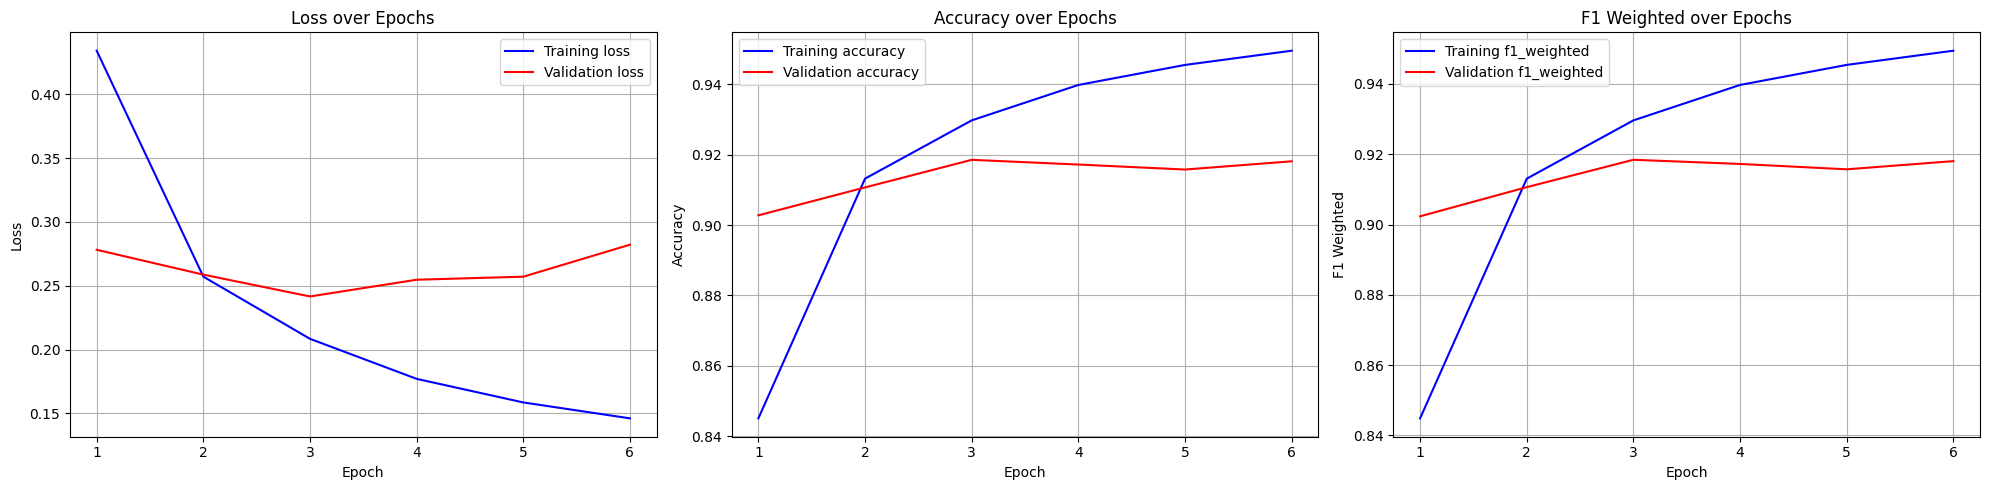

In [99]:
plot_training_history(history)

The metrics show the performance of the model during the training process.

1. Loss Curves
    - Training loss (blue) shows steady decrease over 6 epochs, from ~0.43 to ~0.15
    - Validation loss (red) plateaus around 0.25, with a slight increase at the end. The gap between curves indicates overfitting

2. Accuracy Curves
    - Training accuracy steadily improves from 84% to about 94%
    - Validation accuracy plateaus around 92% after epoch 3
    - The growing separation between curves confirms overfitting

3. F1-Weghted Score
    - Shows very similar patterns to the accuracy curves.
    - Training F1 reaches ~94% while validation F1 plateaus at ~92%.


### Confusion Matrix


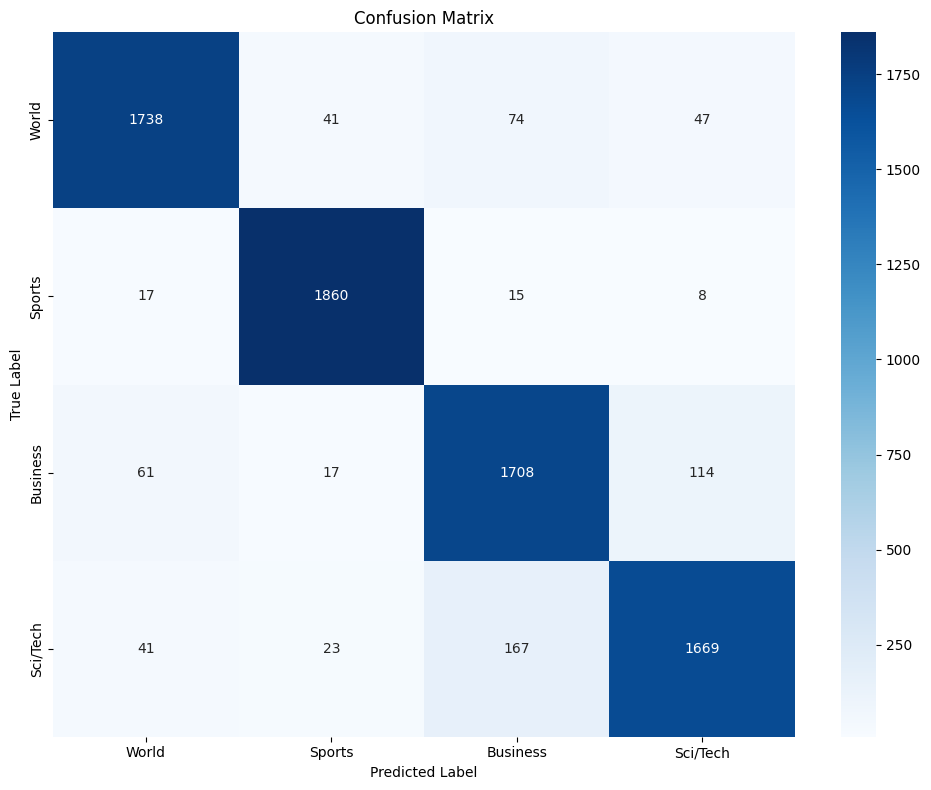

In [100]:
labels = ["World", "Sports", "Business", "Sci/Tech"]
cm = trainer.create_confusion_matrix()

plot_confusion_matrix(cm, labels)

The model classifies news articles into 4 categories: World, Sports, Business, and Science/Technology. The confusion matrix shows the distribution of true and predicted labels for each class.

1. Strong diagonal values show good overall classification
    - World: 1738 correct predictions
    - Sports: 1860 correct predictions
    - Business: 1708 correct predictions
    - Science/Technology: 1669 correct predictions

2. Notable misclassifications:
    - Business and Sci/Tech show the highest mutual confusion (114 Business articles classified as Sci/Tech, 167 Sci/Tech articles as Business)
    - World has moderate confusion with Business (74 cases) and Sci/Tech (47 cases)
    - Sports shows the least confusion with other categories, suggesting more distinctive features

In [101]:
results = trainer.evaluate(test_loader)

Calculating metrics:   0%|          | 0/238 [00:00<?, ?it/s]

In [102]:
print(f"Test Loss: {results['loss']:.4f}")
print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test F1 (Weighted): {results['f1_weighted']:.4f}")

Test Loss: 0.2507
Test Accuracy: 0.9178
Test F1 (Weighted): 0.9177


### Test Results & Metrics


In [103]:
test_metrics = trainer.evaluate(test_loader)
print(pd.DataFrame(test_metrics["classification_report"]).T)

Calculating metrics:   0%|          | 0/238 [00:00<?, ?it/s]

              precision    recall  f1-score      support
0              0.935918  0.914737  0.925206  1900.000000
1              0.958269  0.978947  0.968498  1900.000000
2              0.869654  0.898947  0.884058  1900.000000
3              0.908052  0.878421  0.892991  1900.000000
accuracy       0.917763  0.917763  0.917763     0.917763
macro avg      0.917973  0.917763  0.917688  7600.000000
weighted avg   0.917973  0.917763  0.917688  7600.000000


### Text Classification


In [104]:
def classify_text(
    text: str, model: nn.Module, dataset: NewsDataset
) -> Tuple[int, np.ndarray]:
    """
    Classifies a single text input using the trained model instance.

    Args:
        text (str): Input text to classify.
        model (nn.Module): Trained text classification model.
        dataset (NewsDataset): Dataset instance for text processing.

    Returns:
        Tuple[int, np.ndarray]: Predicted class index and class probabilities.
    """

    model.eval()

    tokens = dataset._tokenize(text)
    ids = dataset._convert_to_ids(tokens)

    x = torch.tensor([ids], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(x)
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(output, dim=1).item()

    return pred_class, probs[0].cpu().numpy()

In [105]:
test_texts = [
    "SpaceX successfully launches rocket to ISS",
    "Manchester United wins Premier League match",
    "Stock market reaches new high",
    "New AI breakthrough in quantum computing",
]

In [106]:
labels = ["World", "Sports", "Business", "Sci/Tech"]

In [107]:
print("\nTesting classification examples:")
for text in test_texts:
    pred_class, probs = classify_text(text, model, train_dataset)

    print(f"\nText: {text}")
    print(f"Predicted class: {labels[pred_class]}")
    print("Class probabilities:")

    for label, prob in zip(labels, probs):
        print(f"{label}: {prob:.4f}")


Testing classification examples:

Text: SpaceX successfully launches rocket to ISS
Predicted class: Sci/Tech
Class probabilities:
World: 0.2880
Sports: 0.0061
Business: 0.0433
Sci/Tech: 0.6626

Text: Manchester United wins Premier League match
Predicted class: Sports
Class probabilities:
World: 0.2612
Sports: 0.7375
Business: 0.0011
Sci/Tech: 0.0002

Text: Stock market reaches new high
Predicted class: Business
Class probabilities:
World: 0.0902
Sports: 0.0024
Business: 0.8786
Sci/Tech: 0.0288

Text: New AI breakthrough in quantum computing
Predicted class: World
Class probabilities:
World: 0.7866
Sports: 0.0026
Business: 0.0585
Sci/Tech: 0.1523
